In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tf.compat.v1.disable_eager_execution()
tf1 = tf.compat.v1
print("Tensorflow version: ",tf.__version__)
import warnings
warnings.filterwarnings('ignore', '.*do not.*', )

Tensorflow version:  2.6.0


In [11]:
dataset_name = "q1"
product_name = "hcho"
file_path = 'dataset/'+dataset_name+'.csv'
data = pd.read_csv(file_path)
data.head(8)

0.0008116600220091642

In [3]:
num_periods = 7  # 7 day
dataset_len = np.rint(np.rint(len(data[product_name])/10)-1)*10
tmp = np.array(data[product_name])

# Normalization: Chuan hoa du lieu => [0,1]
print('===> Min max scaling')
from sklearn import preprocessing as pp
mms = pp.MinMaxScaler()
data_mms = mms.fit_transform(tmp.reshape(-1,1))
print("===> mms", data_mms, "\nmin: ",data_mms.min(),"\nmean: ",data_mms.mean(),"\nmax: ",data_mms.max(),)


df = tmp[:dataset_len.astype(int)+1]
print("===> do dai dataset thuc te", len(tmp),"\n do dai dataset thuc hien: (+1)", dataset_len.astype(int))

f_horizon = 1
x_data = df[:(len(df)-1)]  # x: (ngay 1) den (ngay cuoi cung - 2)
x_batches = x_data.reshape(-1, num_periods, 1)

print("===> x data ", product_name,": \n", x_data, "\n===> x batches: \n", x_batches,
      "\n===> shape x batches\n", x_batches.shape, "\n")

y_data = df[1:(len(df)-1)+f_horizon]
y_batches = y_data.reshape(-1, num_periods, 1)

print("===> y data ", product_name,": \n",  y_data, "\n===> y batches: \n", y_batches,
      "\n===> shape y batches\n", y_batches.shape, "\n")


===> Min max scaling
===> mms [[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.        ]
 [0.36301023]
 [0.        ]] 
min:  0.0 
mean:  0.17171472892190193 
max:  1.0
===> do dai dataset thuc te 1199 
 do dai dataset thuc hien: (+1) 1190
===> x data  hcho : 
 [0. 0. 0. ... 0. 0. 0.] 
===> x batches: 
 [[[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.00030049]
  [0.00044563]
  [0.00026044]
  ...
  [0.00013308]
  [0.00050226]
  [0.        ]]

 ...

 [[0.00017796]
  [0.        ]
  [0.        ]
  ...
  [0.00019234]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]] 
===> shape x batches
 (170, 7, 1) 

===> y data  hcho : 
 [0.         0.         0.         ... 0. 

In [4]:
def test_data(series, forecast, num):
    testX = df[-(num + forecast):][:num].reshape(-1, num_periods, 1)
    testY = df[-(num):].reshape(-1, num_periods, 1)
    return testX, testY
    
X_test, Y_test = test_data(df, f_horizon, num_periods * 2) # 2 periods
print(X_test.shape)
print("===> Y_test: \n",Y_test)


(1, 7, 1)
===> Y_test: 
 [[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.00013188]]]


In [5]:
tf1.reset_default_graph()
inputs = 1
rnn_size = 100
output = 1
learning_rate=0.001
dropout_keep_prob = tf1.placeholder(tf.float32)

X = tf1.placeholder(tf.float32, [None, num_periods, 1])
Y = tf1.placeholder(tf.float32, [None, num_periods, 1])

rnn_cells=tf1.nn.rnn_cell.BasicRNNCell(num_units=rnn_size, activation=tf.nn.relu)
rnn_output, states = tf1.nn.dynamic_rnn(rnn_cells, X, dtype=tf.float32)


output=tf.reshape(rnn_output, [-1, rnn_size])
logit=tf1.layers.dense(output, 1, name="softmax")

outputs=tf.reshape(logit, [-1, num_periods, 1])
print(logit)

loss = tf.reduce_sum(tf.square(outputs - Y))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logit, 1), tf.cast(Y, tf.int64)), tf.float32))

optimizer = tf1.train.AdamOptimizer(learning_rate=learning_rate)
train_step=optimizer.minimize(loss)

init=tf1.global_variables_initializer()

print("===> loss: ", loss, "\n===> accuracy: ", accuracy , optimizer.minimize(loss) )

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/Users/nguyenthanhphong/opt/anaconda3/lib/python3.8/site-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:415: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be "
/Users/nguyenthanhphong/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Tensor("softmax/BiasAdd:0", shape=(None, 1), dtype=float32)


/Users/nguyenthanhphong/opt/anaconda3/lib/python3.8/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/nguyenthanhphong/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


===> loss:  Tensor("Sum:0", shape=(), dtype=float32) 
===> accuracy:  Tensor("Mean:0", shape=(), dtype=float32) name: "Adam_1"
op: "NoOp"
input: "^Adam_1/update_rnn/basic_rnn_cell/kernel/ResourceApplyAdam"
input: "^Adam_1/update_rnn/basic_rnn_cell/bias/ResourceApplyAdam"
input: "^Adam_1/update_softmax/kernel/ResourceApplyAdam"
input: "^Adam_1/update_softmax/bias/ResourceApplyAdam"
input: "^Adam_1/AssignVariableOp"
input: "^Adam_1/AssignVariableOp_1"



In [6]:
epochs = 1000

sess = tf1.Session()
init = tf1.global_variables_initializer()
sess.run(init)
saver = tf1.train.Saver()

for epoch in range(epochs):
    train_dict = {X: x_batches, Y: y_batches, dropout_keep_prob:0.5}
    sess.run(train_step, feed_dict=train_dict)
    
y_pred=sess.run(outputs, feed_dict={X: X_test})
save_path = saver.save(sess, "models/rnn/"+dataset_name+"/"+product_name+"/"+product_name+".ckpt")

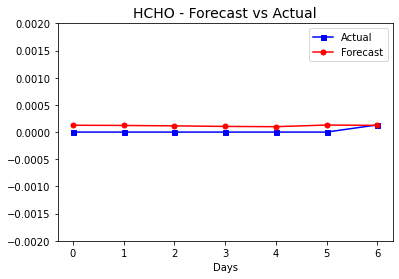

In [15]:
plt.title(product_name.upper() + " - Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bs-", markersize=5, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), "ro-", markersize=5, label="Forecast")
#plt.legend(loc="upper left")
plt.legend(loc="best")
plt.xlabel("Days")
plt.ylim([-0.002,0.002])
plt.show()

In [8]:
with tf1.Session() as sess:
  # Restore variables from disk.
    saver.restore(sess, "models/rnn/"+dataset_name+"/"+product_name+"/"+product_name+".ckpt")
    predict=sess.run(outputs, feed_dict={X: 
    [[[1.4241785e-05],
  [11.6847160e-05],
  [2.0498410e-05],
  [1.8807594e-05],
  [1.1699350e-05],
  [1.1699350e-05],
  [1.1699350e-05]]]}) #nhập num_periods ngày quá khứ, dự đoán num_periods ngày tương lai
print(predict)

INFO:tensorflow:Restoring parameters from models/rnn/q1/hcho/hcho.ckpt
[[[0.00012812]
  [0.00014216]
  [0.00011823]
  [0.0001057 ]
  [0.00010165]
  [0.00013139]
  [0.00012546]]]


In [9]:
print(y_pred) #base on X_test

[[[1.26091763e-04]
  [1.21925259e-04]
  [1.14104245e-04]
  [1.04301726e-04]
  [9.91774723e-05]
  [1.29614142e-04]
  [1.23306760e-04]]]
